<a href="https://colab.research.google.com/github/sowmen/face_recognition_demo/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If running from google colab
!git clone https://github.com/sowmen/face_recognition_demo.git
%cd face_recognition_demo/

Cloning into 'face_recognition_demo'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 34 (delta 3), reused 24 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.
/content/face_recognition_demo


In [2]:
!pip install face_recognition
!pip install dlib

     |████████████████████████████████| 100.2MB 84kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=3cd4a3394ddb65b5f5127cef5f732c21b09ee65a8c1ff36bb9f2f2540372251b
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import os
from tqdm import tqdm
import pickle
from glob import glob

## Create embeddings from image database

In [4]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [22]:
DIR = 'mark-hamill' # Set the directory containing train images to use as base

In [24]:
images = []
face_locations = []
face_embeddings = []
for f in tqdm(os.listdir(DIR)):
    if f.endswith('pkl'):
        continue
    im = cv2.imread(os.path.join(DIR, f))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = image_resize(im, 512)

    locations = face_recognition.face_locations(im) # Detect face bounding box
    if len(locations) > 0:
        face_location = locations[0]
        face_embedding = face_recognition.face_encodings(im)[0] # Compute face embedding
        
        images.append(im)
        face_locations.append(face_location)
        face_embeddings.append(face_embedding)

if len(face_locations) == 0:
    print("\nNo faces were detected in any of the images. Try different set of images")
else:
    print(f"\nDetected {len(face_locations)} faces.")

100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Detected 5 faces.


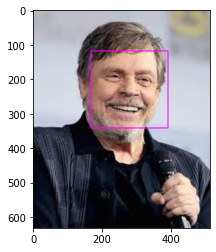

In [25]:
# Visualize a random sample from the directory
id = np.random.randint(0, len(images))
sample = images[id]
cv2.rectangle(sample, (face_locations[id][3], face_locations[id][0]), (face_locations[id][1], face_locations[id][2]), (255,0,255), 2)
plt.imshow(sample)
plt.show()

### Save the precomputed face embeddings

In [26]:
def save_embeddings(embeddings, path, overwrite=True):
    if os.path.exists(path) and overwrite == False:
        print(f"File {path} exists. To overwrite set 'overwrite=True'")
        return
    
    with open(path, "wb") as f:
        pickle.dump(embeddings, f)

# Save the precomputed face embeddings. This will be loaded later to recognize new images
save_embeddings(face_embeddings, os.path.join(DIR,DIR+"_embedding.pkl"), overwrite=False)

File mark-hamill/mark-hamill_embedding.pkl exists. To overwrite set 'overwrite=True'


## Test on a new image againts the entire databse

In [27]:
def search_for_match(test_image):
    test_image_embedding = face_recognition.face_encodings(test_image)[0]

    database_paths = glob('*/**/*embedding*.pkl', recursive=True)
    print(f"\nFound {len(database_paths)} saved embeddings")

    databse_embeddings = []
    for p in tqdm(database_paths, desc="Loading embeddings from databse"):
        with open(p, "rb") as f:
            databse_embeddings.append(pickle.load(f))

    for i, embedding in enumerate(databse_embeddings):
        results = face_recognition.compare_faces(embedding, test_image_embedding)
        distances = face_recognition.face_distance(embedding, test_image_embedding)
        if True in results:
            found = 1
            return True , (database_paths[i], round(min(distances), 3))
    return False, ()

# Testing a different image to check for similarity
test_image = cv2.imread('hamill_test.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = image_resize(test_image, 512)

found, details = search_for_match(test_image)
if found: print(f"Found match in database with {details[0]}, and distance {details[1]}")
else: print("No match found")

Loading embeddings from databse: 100%|██████████| 3/3 [00:00<00:00, 886.81it/s]


Found 3 saved embeddings
Found match in database with mark-hamill/mark-hamill_embedding.pkl, and distance 0.368
